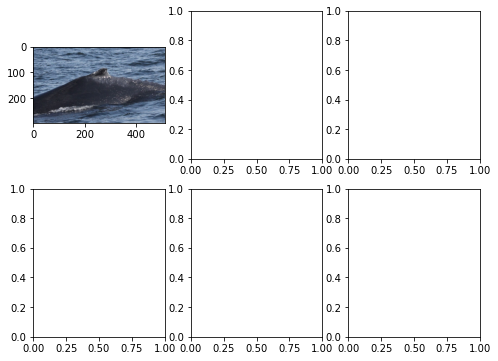

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_df = pd.read_csv('data/train_kfold.csv')
img_dir = 'D:/whalefull/working/data/train_images'
# img_dir = '/Users/macbook/works/train_images-384-384'
ids = train_df[train_df.sample_count == 1].individual_id.unique()

def random_show(train_df):
    iid = np.random.choice(ids)
    samples = train_df[train_df.individual_id == iid]
    imgs = []
    for i, row in samples.iterrows():
        img = cv2.imread(f'{img_dir}/{row.image}')[:, :, ::-1]
        if img is not None:
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(train_df)

In [2]:
x = pd.read_csv('data/train_image_size.csv')
x['r'] = x.w / x.h
x = x.sort_values('h')

,Unnamed: 0,image,h,w,r
42728,42728,8a1924e8bb4143.jpg,41,180,4.390244
49907,49907,f640359d036539.jpg,42,304,7.238095
18650,18650,c6e133317f4ce6.jpg,45,154,3.422222
37818,37818,a0cbb72ef31aa3.jpg,46,205,4.456522
24039,24039,b975838988f041.jpg,47,172,3.659574
...,...,...,...,...,...
1301,1301,f461e90a1a0909.jpg,5277,3599,0.682016
13032,13032,f75296ec47f806.jpg,5277,3599,0.682016
48074,48074,015b9c7df6b33a.jpg,5277,3599,0.682016
41469,41469,99c03bb23874cd.jpg,5399,3599,0.666605


In [3]:
len(x[x['r'] >= 3])

9768

15


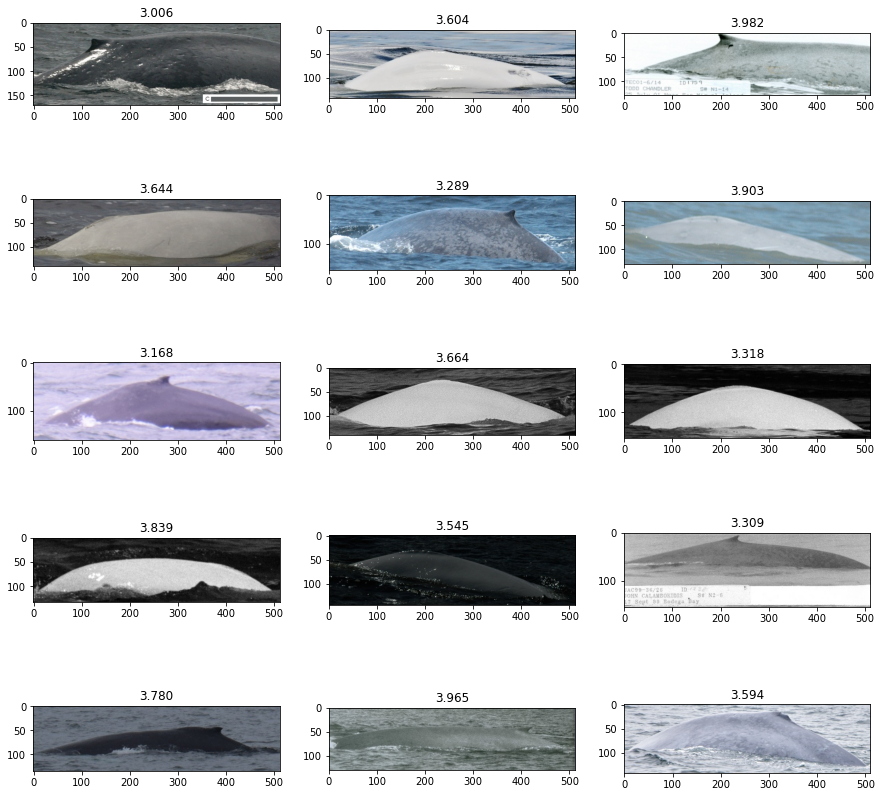

In [4]:
# Show some dataset
imgs = []
for i, row in x[(x['r'] >= 3) & (x['r'] <=4)].sample(100).iterrows():
    img = cv2.imread(img_dir + '/' + row.image)
    if img is not None:
        imgs.append([img[:,:,::-1], row['r']])

    if len(imgs)  == 15:
        break

print(len(imgs))
fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    im, r = imgs[i-1]
    plt.title(f"{r:.3f}")
    plt.imshow(im)
plt.show()

In [1]:
plt.imshow(cv2.imread(f"{img_dir}/3aa9888f58.jpg")[:,:,::-1])

NameError: name 'plt' is not defined

In [62]:
from functools import partial

def decode_image(image_data, bb):
    if bb is not None and bb[0] != -1:
        left, top, right, bottom = bb[0], bb[1], bb[2], bb[3]
        bbs = tf.convert_to_tensor([top, left, bottom - top, right - left])
        image = tf.io.decode_and_crop_jpeg(image_data, bbs, channels=3)
    else:
        image = tf.image.decode_jpeg(image_data, channels = 3)

    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize(image,IMAGE_SIZE_)
    return image

def read_labeled_tfrecord(example, crop_method='detic'):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        'target': tf.io.FixedLenFeature([], tf.int64),
        'species': tf.io.FixedLenFeature([], tf.int64),
        # 'yolov5_box': tf.io.FixedLenFeature([4], tf.int64),
        'detic_box': tf.io.FixedLenFeature([4], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    bb = None
    if crop_method == 'detic':
        bb = tf.cast(example['detic_box'], tf.int32)
    # elif crop_method == 'yolov5':
    #     bb = tf.cast(example['yolov5_box'], tf.int32)

    image = decode_image(example['image'], bb)
    label = example['target']
    return image, label, example['species']

def load_dataset(filenames, crop_method, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_labeled_tfrecord, crop_method=crop_method))
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import math

# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

from matplotlib import patches

def batch_to_numpy_images_and_labels(data):
    images, labels, species = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    species_labels = species.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels, species_labels

def display_single_sample(image, label, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')

    plt.imshow(image)

    title = str(label)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch):
    """
    Display single batch Of images 
    """
    # data
    images, labels, species = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(
        images[:rows*cols],
        labels[:rows*cols]
    )):
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_single_sample(image, label, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    predictions = None
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

1


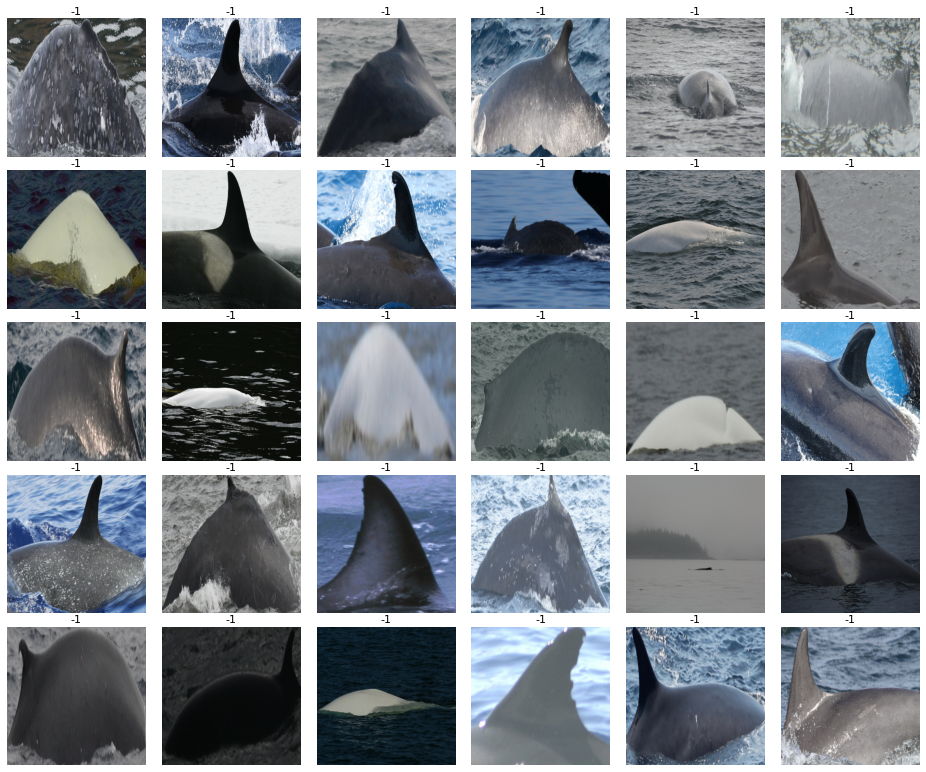

In [64]:
# read tf record
import tensorflow as tf
IMAGE_SIZE=512

IMAGE_SIZE_ = [IMAGE_SIZE,IMAGE_SIZE]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(f'c:/Users/msi/Downloads/data1/happywhale-2022-test*.tfrec')
print(len(TRAINING_FILENAMES))
dataset = load_dataset(TRAINING_FILENAMES, crop_method='detic', labeled=True)
dataset = dataset.repeat()
# dataset = dataset.shuffle(2048)
dataset = dataset.batch(32)
dataset = dataset.prefetch(AUTO) #This dataset can directly be passed to keras.fit method

# Displaying single batch of TFRecord
train_batch = iter(dataset)
display_batch_of_images(next(train_batch))

In [6]:
import numpy as np
from tf_code.losses import SparseCategoricalFocalLoss, CeLoss
import tensorflow as tf

y_true = np.array([0, 1, 2, 2, 1, 0])
y_pred = np.array([[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 0.0, 1.0]])


print(tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred))
print(SparseCategoricalFocalLoss(gamma=0.0)(y_true, y_pred))
print(CeLoss(ohem=True, n_classes=3)(y_true, y_pred))

tf.Tensor(3.1491897106170654, shape=(), dtype=float64)
tf.Tensor(3.1491897106170654, shape=(), dtype=float64)
tf.Tensor([16.1180954   1.09861231], shape=(2,), dtype=float64)
tf.Tensor([16.1180954   1.09861231], shape=(2,), dtype=float64)
tf.Tensor(8.608353614807129, shape=(), dtype=float64)
